# 2D Latent Diffusion Model

In [2]:
# TODO: Add buttom with "Open with Colab"

## Set up environment using Colab


In [3]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Set up imports

In [40]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet
from generative.networks.nets.patchgan_discriminator import PatchDiscriminator
from generative.schedulers import DDPMScheduler

print_config()

MONAI version: 1.1.dev2239
Numpy version: 1.23.4
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 13b24fa92b9d98bd0dc6d5cdcb52504fd09e297b
MONAI __file__: /home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, plea

In [5]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpdk8a8m2c


## Download the training set

In [7]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        # TODO: Change transformations
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)

MedNIST.tar.gz: 59.0MB [00:00, 103MB/s]                                                                                                                                                                                                             

2022-11-30 08:46:24,049 - INFO - Downloaded: /tmp/tmpdk8a8m2c/MedNIST.tar.gz


2022-11-30 08:46:24,153 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-30 08:46:24,154 - INFO - Writing into directory: /tmp/tmpdk8a8m2c.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:17<00:00, 2645.88it/s]


## Visualise examples from the training set

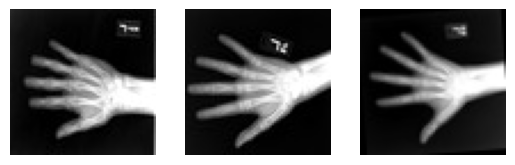

In [8]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

## Download the validation set

In [9]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4)

2022-11-30 08:46:48,099 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-30 08:46:48,099 - INFO - File exists: /tmp/tmpdk8a8m2c/MedNIST.tar.gz, skipped downloading.
2022-11-30 08:46:48,100 - INFO - Non-empty folder exists in /tmp/tmpdk8a8m2c/MedNIST, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:02<00:00, 2741.19it/s]


## Define the network

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [35]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=32,
    latent_channels=3,
    ch_mult=(1, 2, 2),
    num_res_blocks=1,
    norm_num_groups=16,
    attention_levels=(False, False, True),
)

In [50]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=1,
    attention_resolutions=[4, 2],
    channel_mult=[1, 2, 2],
    model_channels=32,
    num_heads=1,
)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    beta_start=0.0015,
    beta_end=0.0195,
)

inferer = DiffusionInferer(scheduler)

discriminator = PatchDiscriminator(
    spatial_dims=3,
    num_layers_d=3,
    num_channels=32,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation="LEAKYRELU",
    norm="BATCH",
    bias=False,
    padding=(1, 1, 1),
)
discriminator.to(device)

In [ ]:
perceptual_loss = PerceptualLoss(spatial_dims=3, network_type="squeeze", fake_3d_ratio=0.25)
perceptual_loss.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01
perceptual_weight = 0.001

optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), 1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

## Train AutoencoderKL

In [37]:
autoencoderkl = autoencoderkl.to(device)
kl_weight = 1e-6
kl_optimizer = torch.optim.Adam(autoencoderkl.parameters(), 1e-5)
n_epochs = 50
val_interval = 10
kl_epoch_loss_list = []
kl_val_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    autoencoderkl.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        kl_optimizer.zero_grad(set_to_none=True)
        reconstruction, z_mu, z_sigma = autoencoderkl(images)

        rec_loss = F.l1_loss(reconstruction.float(), images.float())

        kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
        kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

        # TODO: Add adversarial component
        # TODO: Add perceptual loss

        loss = rec_loss + kl_weight * kl_loss
        loss.backward()
        kl_optimizer.step()
        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    kl_epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                kl_optimizer.zero_grad(set_to_none=True)
                reconstruction, z_mu, z_sigma = autoencoderkl(images)
                # TODO: Remove this
                # Get the first sammple from the first validation batch for visualisation
                # purposes
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                rec_loss = F.l1_loss(images.float(), reconstruction.float())

                kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
                kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

                # TODO: Add adversarial component
                # TODO: Add perceptual loss

                loss = rec_loss + kl_weight * kl_loss
                val_loss += loss.item()

        val_loss /= val_step
        kl_val_epoch_loss_list.append(val_loss)

        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()


Epoch 9: 100%|█████████| 125/125 [00:16<00:00,  7.78it/s, loss=0.0603]


epoch 10 val loss: 0.0617


Epoch 19: 100%|█████████| 125/125 [00:16<00:00,  7.77it/s, loss=0.046]


epoch 20 val loss: 0.0482


Epoch 29: 100%|████████| 125/125 [00:16<00:00,  7.78it/s, loss=0.0393]


epoch 30 val loss: 0.0414


Epoch 39: 100%|████████| 125/125 [00:15<00:00,  7.82it/s, loss=0.0353]


epoch 40 val loss: 0.0375


Epoch 49: 100%|████████| 125/125 [00:16<00:00,  7.76it/s, loss=0.0325]


epoch 50 val loss: 0.0346


### Visualise the results from the autoencoderKL

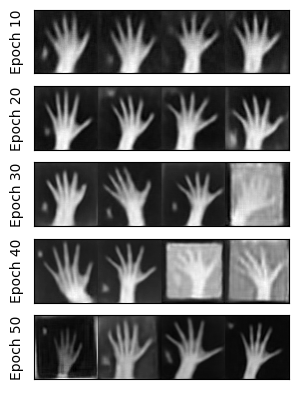

In [38]:
val_samples = np.linspace(val_interval, n_epochs, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=len(val_samples), ncols=1, sharey=True)
for image_n in range(len(val_samples)):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * n_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

## Train Diffusion Model

Epoch 3: 100%|██████████| 125/125 [00:13<00:00,  9.58it/s, loss=0.113]


Epoch 3 val loss: 0.1039


100%|████████████████████████████| 1000/1000 [00:09<00:00, 104.22it/s]


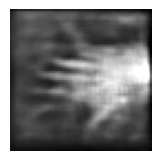

Epoch 7: 100%|█████████| 125/125 [00:13<00:00,  9.58it/s, loss=0.0954]


Epoch 7 val loss: 0.0954


100%|████████████████████████████| 1000/1000 [00:09<00:00, 104.24it/s]


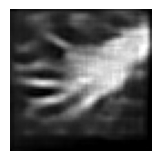

Epoch 11: 100%|█████████| 125/125 [00:13<00:00,  9.60it/s, loss=0.093]


Epoch 11 val loss: 0.0902


100%|████████████████████████████| 1000/1000 [00:09<00:00, 104.52it/s]


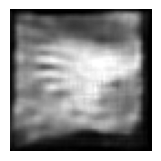

Epoch 15: 100%|████████| 125/125 [00:13<00:00,  9.57it/s, loss=0.0856]


Epoch 15 val loss: 0.0868


100%|████████████████████████████| 1000/1000 [00:09<00:00, 105.56it/s]


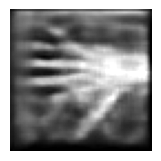

Epoch 19: 100%|████████| 125/125 [00:12<00:00,  9.71it/s, loss=0.0855]


Epoch 19 val loss: 0.0864


100%|████████████████████████████| 1000/1000 [00:09<00:00, 104.66it/s]


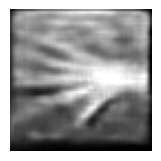

Epoch 23: 100%|████████| 125/125 [00:12<00:00,  9.65it/s, loss=0.0864]


Epoch 23 val loss: 0.0857


100%|████████████████████████████| 1000/1000 [00:09<00:00, 105.50it/s]


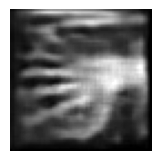

Epoch 27: 100%|████████| 125/125 [00:13<00:00,  9.51it/s, loss=0.0823]


Epoch 27 val loss: 0.0827


100%|████████████████████████████| 1000/1000 [00:09<00:00, 103.97it/s]


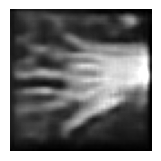

Epoch 31: 100%|████████| 125/125 [00:12<00:00,  9.64it/s, loss=0.0817]


Epoch 31 val loss: 0.0816


100%|████████████████████████████| 1000/1000 [00:09<00:00, 103.45it/s]


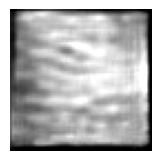

Epoch 35: 100%|████████| 125/125 [00:12<00:00,  9.64it/s, loss=0.0785]


Epoch 35 val loss: 0.0825


100%|████████████████████████████| 1000/1000 [00:09<00:00, 104.71it/s]


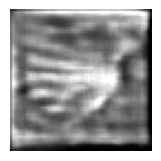

Epoch 39: 100%|████████| 125/125 [00:12<00:00,  9.64it/s, loss=0.0832]


Epoch 39 val loss: 0.0784


100%|████████████████████████████| 1000/1000 [00:09<00:00, 104.34it/s]


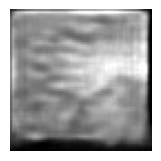

Epoch 43: 100%|████████| 125/125 [00:13<00:00,  9.47it/s, loss=0.0797]


Epoch 43 val loss: 0.0756


100%|████████████████████████████| 1000/1000 [00:09<00:00, 105.13it/s]


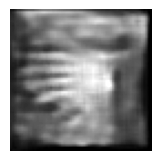

Epoch 47: 100%|████████| 125/125 [00:13<00:00,  9.58it/s, loss=0.0785]


Epoch 47 val loss: 0.0763


100%|████████████████████████████| 1000/1000 [00:09<00:00, 104.38it/s]


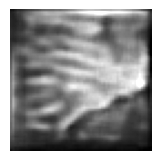

Epoch 49: 100%|████████| 125/125 [00:12<00:00,  9.63it/s, loss=0.0784]


In [51]:
optimizer = torch.optim.Adam(unet.parameters(), lr=2.5e-4)
# TODO: Add lr_scheduler with warm-up
# TODO: Add EMA model

unet = unet.to(device)
n_epochs = 50
val_interval = 4
epoch_loss_list = []
val_epoch_loss_list = []

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        z_mu, z_sigma = autoencoderkl.encode(images)
        z = autoencoderkl.sampling(z_mu, z_sigma)

        noise = torch.randn_like(z).to(device)
        noise_pred = inferer(inputs=z, diffusion_model=unet, noise=noise)
        loss = F.mse_loss(noise_pred.float(), noise.float())

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                optimizer.zero_grad(set_to_none=True)

                z_mu, z_sigma = autoencoderkl.encode(images)
                z = autoencoderkl.sampling(z_mu, z_sigma)

                noise = torch.randn_like(z).to(device)
                noise_pred = inferer(inputs=z, diffusion_model=unet, noise=noise)

                loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_epoch_loss_list.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        z = torch.randn((1, 3, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        for t in tqdm(scheduler.timesteps, ncols=70):
            # 1. predict noise model_output
            with torch.no_grad():
                model_output = unet(z, torch.Tensor((t,)).to(device))

                # 2. compute previous image: x_t -> x_t-1
                z, _ = scheduler.step(model_output, t, z)

        with torch.no_grad():
            decoded = autoencoderkl.decode(z)
        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()


### Plotting sampling example

In [ ]:
unet.eval()
image = torch.randn(
    (1, 1, 64, 64),
)
image = image.to(device)
scheduler.set_timesteps(num_inference_steps=1000)

intermediary = []
for t in tqdm(scheduler.timesteps, ncols=70):
    # 1. predict noise model_output
    with torch.no_grad():
        z_mu, z_sigma = autoencoderkl.encode(image)
        z = autoencoderkl.sampling(z_mu, z_sigma)
        model_output = unet(z, torch.Tensor((t,)).to(device))

        # 2. compute previous image: x_t -> x_t-1
        r_image, _ = scheduler.step(model_output, t, z)
        if t % 100 == 0:
            intermediary.append(r_image)


In [ ]:
# Invert the autoencoderKL model
decoded_images = []
for image in intermediary:
    with torch.no_grad():
        decoded = autoencoderkl.decode(r_image)
        decoded_images.append(decoded)
plt.figure()
chain = torch.cat(decoded_images, dim=-1)
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")

In [ ]:
# ## Plot learning curves
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})

In [ ]:
### Clean-up data directory

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)